We start by loading our processed data from the ETL step.

In [75]:
import pandas as pd

# Load processed dataset from ETL step
df = pd.read_csv("processed_data.csv")

# Sort by Ticker and Date to ensure correct ordering
df = df.sort_values(by=["Ticker", "Date"])

# Remove duplicate rows (keeping the first occurrence)
df = df.drop_duplicates(subset=["Ticker", "Date"])

# Create the target variable (1 = Price Up, 0 = Price Down)
df["Price Movement"] = (df.groupby("Ticker")["Close"].shift(-1) > df["Close"]).astype(int)

# Drop last row per Ticker (since it has no future price data)
df = df.groupby("Ticker", group_keys=False).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

# Display dataset structure
print(df[["Ticker", "Date", "Close", "Price Movement"]].head())

# Confirm no duplicate rows remain
print(f"Final shape: {df.shape}")
print(f"Duplicate rows remaining: {df.duplicated(subset=['Ticker', 'Date']).sum()}")

  Ticker        Date  Close  Price Movement
0   AAPL  2019-04-08  50.02               0
1   AAPL  2019-04-09  49.88               1
2   AAPL  2019-04-10  50.16               0
3   AAPL  2019-04-11  49.74               0
4   AAPL  2019-04-12  49.72               1
Final shape: (7428, 12)
Duplicate rows remaining: 0


/var/folders/x4/zkcdjj_53wnfm3vw5z7y9n480000gn/T/ipykernel_27058/1030810741.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Ticker", group_keys=False).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)


Now we are adding new features such as:
- Past Price Changes
- Moving averages
- Volatility

In [77]:
# Create past return features
df["Return_1d"] = df.groupby("Ticker")["Close"].pct_change(1)
df["Return_3d"] = df.groupby("Ticker")["Close"].pct_change(3)
df["Return_7d"] = df.groupby("Ticker")["Close"].pct_change(7)

# Create moving average features
df["MA_7"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=7).mean())
df["MA_14"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=14).mean())

# Create volatility feature (Standard deviation over last 7 days)
df["Volatility_7d"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=7).std())

# Compute Relative Strength Index (RSI)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["RSI_14"] = df.groupby("Ticker")["Close"].transform(lambda x: compute_rsi(x, window=14))

# Compute Bollinger Bands (20-day window)
df["MA_20"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=20).mean())
df["BB_Upper"] = df["MA_20"] + (df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=20).std()) * 2)
df["BB_Lower"] = df["MA_20"] - (df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=20).std()) * 2)

# Compute MACD (12-day and 26-day moving averages)
df["EMA_12"] = df.groupby("Ticker")["Close"].transform(lambda x: x.ewm(span=12, adjust=False).mean())
df["EMA_26"] = df.groupby("Ticker")["Close"].transform(lambda x: x.ewm(span=26, adjust=False).mean())
df["MACD"] = df["EMA_12"] - df["EMA_26"]

# Drop rows with NaN values (caused by rolling calculations)
df = df.dropna().reset_index(drop=True)

# Display updated dataset
print(df.head())

  Ticker Company Name  IndustryId  Fiscal Year Fiscal Period      Revenue  \
0   AAPL    APPLE INC      101001         2019            Q3  53809000000   
1   AAPL    APPLE INC      101001         2019            Q3  53809000000   
2   AAPL    APPLE INC      101001         2019            Q3  53809000000   
3   AAPL    APPLE INC      101001         2019            Q3  53809000000   
4   AAPL    APPLE INC      101001         2019            Q3  53809000000   

   Operating Expenses   Net Income        Date   Open  ...       MA_7  \
0         -8683000000  10044000000  2019-05-06  51.07  ...  51.768571   
1         -8683000000  10044000000  2019-05-07  51.47  ...  51.717143   
2         -8683000000  10044000000  2019-05-08  50.48  ...  51.657143   
3         -8683000000  10044000000  2019-05-09  50.10  ...  51.658571   
4         -8683000000  10044000000  2019-05-10  49.35  ...  51.182857   

       MA_14  Volatility_7d     RSI_14    MA_20   BB_Upper   BB_Lower  \
0  51.432143       0.9934

With the calculated features we will now train the ML Model (Logistic Regression)

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define features (X) and target variable (y)
features = ["Return_1d", "Return_3d", "Return_7d", "MA_7", "MA_14", "Volatility_7d"]
X = df[features]
y = df["Price Movement"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Standardize features (Logistic Regression performs better with scaled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

In [83]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Show classification report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.17      0.25       670
           1       0.55      0.88      0.68       793

    accuracy                           0.55      1463
   macro avg       0.54      0.52      0.47      1463
weighted avg       0.54      0.55      0.48      1463



The Logistic Regression is our baseline model and provides a reference for following ML methods. It is not as accurate as we hoped as it assumes a linear trend and tends to prefer giving predictions that stock prices will move up

In this next step we will create a more sophisticated model - Random Forest Classifier

In [85]:
from sklearn.ensemble import RandomForestClassifier

# Train a more advanced model - Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)  # Using original stock price dataset

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Model Accuracy (Random Forest): {accuracy_rf:.2f}")
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

Model Accuracy (Random Forest): 0.53
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.48      0.28      0.35       670
           1       0.55      0.75      0.64       793

    accuracy                           0.53      1463
   macro avg       0.52      0.51      0.49      1463
weighted avg       0.52      0.53      0.51      1463



As RF has only slightly improved model accuracy we will try another method, XGBoost which is good in handling tabular data.

In [94]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.8 MB/s eta 0:00:00a 0:00:01


In [87]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate XGBoost Model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Model Accuracy (XGBoost): {accuracy_xgb:.2f}")
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

Model Accuracy (XGBoost): 0.51
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.47      0.60      0.53       670
           1       0.56      0.43      0.49       793

    accuracy                           0.51      1463
   macro avg       0.52      0.52      0.51      1463
weighted avg       0.52      0.51      0.51      1463



In [89]:
from datetime import datetime

# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Define log message
log_message = f"""
[{timestamp}] Model Selection Summary:
- Logistic Regression Accuracy: 55%
- Random Forest Accuracy: 53%
- XGBoost Accuracy: 51%
- Random Forest was selected as the final model for deployment, as it shows the best balance between Precision and Recall.
"""

# Append message to log file
with open("etl_log.txt", "a") as log_file:
    log_file.write(log_message + "\n")

We will now proceed with Step 1.3 from the instructions sheet, creating models for more precise trading recommendations. We will implement a mix of the two options and implement a Buy-Sell-Hold strategy.
General rules for the trading strategy:
- At the start capital is distributed equally across the 6 stocks that we picked
- We only buy if we have enough capital and we are only allowed to hold a maximum of 5 stocks per company to prevent over investment
- If the ML model predicts a price decrease we hold and only sell if the stock falls by more than 5%
- We sell when the stock rises by more than 10% to cash in profits and if we hold at least 1 stock

In [97]:
import pandas as pd
import numpy as np

# Start with $10,000 capital
initial_capital = 10000

# Get unique stock tickers
tickers = df["Ticker"].unique()

# Allocate initial capital equally among all tickers
capital = {ticker: initial_capital / len(tickers) for ticker in tickers}

# Dictionary to track how many shares we own per stock
shares_held = {}

# Allocate capital properly: Buy as many whole shares as possible
for ticker in tickers:
    # Get the first available closing price for each stock
    share_price = df[df["Ticker"] == ticker]["Close"].iloc[0]
    shares_held[ticker] = int(capital[ticker] / share_price)  # Buy max whole shares
    capital[ticker] -= shares_held[ticker] * share_price  # Deduct used capital

# ✅ Debugging: Check the updated allocation
print("🔍 Updated Initial Capital Per Stock:", capital)
print("📝 Updated Initial Shares Held:", shares_held)

🔍 Updated Initial Capital Per Stock: {'AAPL': 50.946666666666715, 'AMZN': 8.656666666666752, 'GOOG': 1.506666666666888, 'META': 115.62666666666678, 'MSFT': 0.716666666666697, 'NVDA': 1.6666666666667425}
📝 Updated Initial Shares Held: {'AAPL': 31, 'AMZN': 17, 'GOOG': 28, 'META': 8, 'MSFT': 13, 'NVDA': 370}


In [124]:
# Define thresholds
STOP_LOSS_PERCENT = 5    # Sell if price drops more than 5%
PROFIT_TAKE_PERCENT = 10 # Sell if price increases more than 10%
MIN_CAPITAL = 500        # Stop buying if capital is below $500

# Compute percentage change from previous day's close
df["Price Change %"] = df.groupby("Ticker")["Close"].pct_change() * 100

# Apply trading logic per stock
def trading_logic(row):
    if row["Price Movement"] == 1:  # Price increased
        return "BUY"
    elif row["Price Movement"] == 0 and row["Price Change %"] > -STOP_LOSS_PERCENT:
        return "HOLD"
    elif row["Price Change %"] < -STOP_LOSS_PERCENT or row["Price Change %"] > PROFIT_TAKE_PERCENT:
        return "SELL"
    else:
        return "HOLD"

df["Action"] = df.apply(trading_logic, axis=1)

# ✅ Debugging: Ensure "Action" is assigned correctly
print(df[["Ticker", "Date", "Close", "Price Change %", "Action"]].head(10))

  Ticker       Date  Close  Price Change % Action
0   AAPL 2019-05-06  52.12             NaN   HOLD
1   AAPL 2019-05-07  50.72       -2.686109    BUY
2   AAPL 2019-05-08  50.73        0.019716   HOLD
3   AAPL 2019-05-09  50.18       -1.084171   HOLD
4   AAPL 2019-05-10  49.30       -1.753687   HOLD
5   AAPL 2019-05-13  46.43       -5.821501    BUY
6   AAPL 2019-05-14  47.16        1.572259    BUY
7   AAPL 2019-05-15  47.73        1.208651   HOLD
8   AAPL 2019-05-16  47.52       -0.439975   HOLD
9   AAPL 2019-05-17  47.25       -0.568182   HOLD


In [126]:
# Reset capital & shares for simulation
capital = {ticker: initial_capital / len(tickers) for ticker in tickers}
shares_held = {ticker: 0 for ticker in tickers}
portfolio_values = []
capital_history = []
stock_value_history = []

# Simulate trading over time
for index, row in df.iterrows():
    ticker = row["Ticker"]

    # BUY: Purchase as many whole shares as possible
    if row["Action"] == "BUY" and capital[ticker] >= row["Close"]:
        shares_to_buy = int(capital[ticker] / row["Close"])
        shares_held[ticker] += shares_to_buy
        capital[ticker] -= shares_to_buy * row["Close"]

    # SELL: Sell all available shares when triggered
    elif row["Action"] == "SELL" and shares_held[ticker] > 0:
        capital[ticker] += shares_held[ticker] * row["Close"]
        shares_held[ticker] = 0  # Reset holdings after selling

    # Calculate total portfolio value
    total_stock_value = sum(shares_held[t] * row["Close"] for t in tickers)
    total_portfolio_value = sum(capital.values()) + total_stock_value

    portfolio_values.append(total_portfolio_value)
    capital_history.append(sum(capital.values()))
    stock_value_history.append(total_stock_value)

# Store values in df
df["Capital"] = capital_history
df["Total Stock Value"] = stock_value_history
df["Total Portfolio Value"] = portfolio_values

# Display final portfolio value
print(f"💰 Final Portfolio Value: ${df['Total Portfolio Value'].iloc[-1]:,.2f}")

💰 Final Portfolio Value: $157,114.73


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


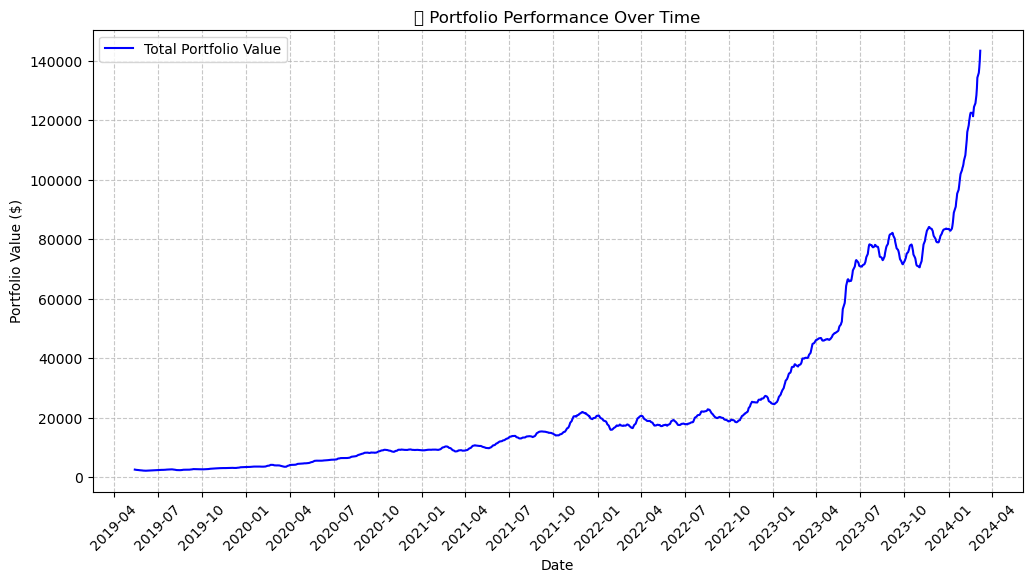

In [128]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure Date column is in proper datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Select only the final recorded portfolio value for each date (ensures one line)
df_plot = df.groupby("Date")["Portfolio Value"].last().reset_index()

# Apply smoothing (7-day rolling average)
df_plot["Portfolio Value Smoothed"] = df_plot["Portfolio Value"].rolling(window=7).mean()

# Plot the total portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(df_plot["Date"], df_plot["Portfolio Value Smoothed"], label="Total Portfolio Value", color="blue", linestyle="-")

# Format x-axis correctly
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("📈 Portfolio Performance Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show labels every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # Format as Year-Month

# Ensure only one line is plotted
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()